# Questioning the Effect of Physiological Heartbeat Synchrony in Romantic Dyads. A Preregistered Deep Learning Analysis.

In [1]:
# For Google Colab / local machine
import tensorflow.keras
ver = tensorflow.version.VERSION

if float(ver[:3]) > 2.7:
  print("Latest TensorFlow version detected -> Prepare Google Colab usage\n")
  google_colab = 1
  from google.colab import drive
  drive.mount('/content/drive/')
  colab_path = "/content/drive/MyDrive/Masterarbeit/Code/two-hearts/"
  import sys
  sys.path.append(colab_path)
else:
  colab_path = ""

In [2]:
# Import libraries
from IPython.display import display
import os
import datetime
import random
from random import randint
import pickle
import IPython
import IPython.display
import numpy as np
from numpy import array, hstack
import pandas as pd
import scipy.stats as st
from copy import deepcopy
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
# mpl.rcParams['font.family'] = 'Arial'
import seaborn as sns
from tensorflow.python.keras.saving import saving_utils
from tensorflow.keras.models import Sequential, Model, load_model
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

from lists import dyads, num_dyads, participants, num_participants

print("TensorFlow version:",tensorflow.version.VERSION)

TensorFlow version: 2.6.0


In [3]:
# Add headers for multiple subplots
# Based on https://stackoverflow.com/a/71887460
def add_headers(
        fig, *, row_headers=None, col_headers=None, row_pad=1, col_pad=5, rotate_row_headers=True, **text_kwargs):
    # Based on https://stackoverflow.com/a/25814386
    axes = fig.get_axes()
    for ax in axes:
        sbs = ax.get_subplotspec()
        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
                col_headers[sbs.colspan.start], 
                xy=(0.5, 1), xytext=(0, col_pad),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center", va="baseline", **text_kwargs,)
        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
                row_headers[sbs.rowspan.start], 
                xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label, textcoords="offset points",
                ha="right", va="center", rotation=rotate_row_headers * 90, 
                **text_kwargs,)


## Model summary

In [4]:
# Load all results
with open('model/data_all.pickle', 'rb') as handle:
    data_all = pickle.load(handle)

In [5]:
# Set sampling rate
sampling_rate = 50
print("Sampling rate:", sampling_rate)

# Set number of time steps
n_steps_in, n_steps_out = 5*sampling_rate, 2*sampling_rate
print("Time steps:", n_steps_in, n_steps_out)

# Set conditions
conditions = ["sit","gaze","gaze_swap"]
print("Conditions:", conditions)

# Show number of participants 
print("Participants:", num_participants)

# Show number of dyads
print("Dyads:", num_dyads)

# Show number of runs
runs = list(data_all.keys())
print("Number of training runs:",len(runs))

Sampling rate: 50
Time steps: 250 100
Conditions: ['sit', 'gaze', 'gaze_swap']
Participants: 8
Dyads: 4
Number of training runs: 3


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 250, 2)]     0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 100), (None, 41200       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 100)          300         lstm_2[0][0]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 100, 100)     0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

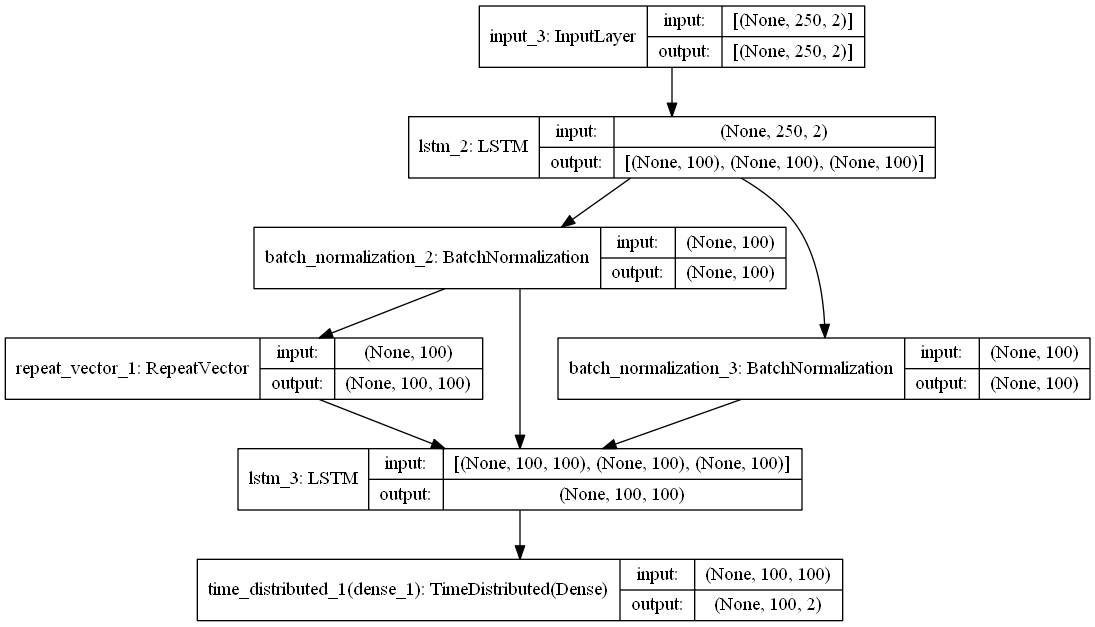

In [6]:
# install nomkl if kernel dies here because of kmp duplicate library
model_example = load_model(data_all["01"]["model_all"]["gaze"])
model_example.summary()
plot_model(
    model_example,
    show_shapes=True,
    show_layer_names=True,
    to_file='plots/keras_model_plot.png')

In [7]:
num_participants = len(participants)
num_dyads = len(dyads)

samples = data_all["01"]["samples_all"]  # samples are the same for each trial
predictions = {}
for run in runs:
    predictions[run] = (data_all[run]["predictions_all"])

len(samples["gaze"]["X_input_train"])
len(samples["gaze"]["y_output_train"])
len(samples["gaze"]["X_input_train"])

print(
    "Number of participants:",
    num_participants)
print(
    "Number of dyads:",
    num_dyads)
print(
    "num_train_samples per dyad:",
    len(samples["gaze"]["X_input_train"])//num_dyads)
print(
    "num_vali_samples per dyad:",
    len(samples["gaze"]["X_input_vali"])//num_dyads)
print(
    "num_test_samples per dyad:",
    len(samples["gaze"]["X_input_test"])//num_dyads)
print(
    "Length of samples for each set:",
    len(samples["gaze"]["X_input_train"]),
    len(samples["gaze"]["X_input_vali"]),
    len(samples["gaze"]["X_input_test"]))


Number of participants: 8
Number of dyads: 4
num_train_samples per dyad: 174
num_vali_samples per dyad: 58
num_test_samples per dyad: 58
Length of samples for each set: 696 232 232


### Model evaluation

In [20]:
# Show saved evaluations
print("Metrics for all trials")

for run in runs:
    print(
        run, data_all[run]["results_all"])

# Calculate means ans stds for both metrics
# MSE
mse_temp = []
mse_all = []
for i, run in enumerate(runs):
    for con in conditions:
        mse_temp.append(data_all[run]["results_all"][con][0])
    mse_all.append(mse_temp)
    mse_temp = []

# MAE
mae_temp = []
mae_all = []
for i, run in enumerate(runs):
    for con in conditions:
        mae_temp.append(data_all[run]["results_all"][con][1])
    mae_all.append(mae_temp)
    mae_temp = []


model_eval = {
    "mse": mse_all,
    "mae": mae_all
}

# Get run number of the highest performing model for each condition
best_run = {}
print("Best runs")
for con in conditions:
    best_run[con] = runs[np.argmin([data_all[run]["results_all"][con][0] for run in runs])]

print(best_run)

Metrics for all trials
01 {'sit': [0.028530549257993698, 0.11703720688819885], 'gaze': [0.026767658069729805, 0.11126668751239777], 'gaze_swap': [0.02831937000155449, 0.1124381572008133]}
02 {'sit': [0.028441406786441803, 0.11573377996683121], 'gaze': [0.027102096006274223, 0.11205077171325684], 'gaze_swap': [0.02458532527089119, 0.106587253510952]}
03 {'sit': [0.026579268276691437, 0.11221860349178314], 'gaze': [0.02545209415256977, 0.10717201232910156], 'gaze_swap': [0.02592020481824875, 0.10809149593114853]}
Best runs
{'sit': '03', 'gaze': '03', 'gaze_swap': '02'}


#### Sanity check

In [21]:
# Sanity check
results_check = model_example.evaluate(
    samples["gaze"]["X_input_test"], 
    samples["gaze"]["y_output_test"], 
    batch_size=64, verbose=0)
print(results_check)
print(data_all["01"]["results_all"]["gaze"]) # compare with saved results from model notebook

[0.026767656207084656, 0.11126667261123657]
[0.026767658069729805, 0.11126668751239777]


### Training epochs

In [ ]:
# Show training length in dataframe

# Prepare nested list
training_length_list = []
for run in runs:
    temp = []
    for j in conditions:
        temp.append(len(data_all[run]["history_all"][j]["loss"]))
    training_length_list.append(temp)
# Save nested list as dictionary
training_length_dict = {}
for i in range(len(training_length_list)):
    training_length_dict[f"Trial {i}"] = training_length_list[i]
# Transform dictionary into dataframe
training_length = pd.DataFrame.from_dict(
    training_length_dict,
    orient='index',
    columns=conditions)
training_length = training_length-50  # patience = 50

print("Training epochs:")
display(training_length)

training_length_info = pd.DataFrame(
    {"sit": [
        training_length.mean(axis=0)[0],
        training_length.std(axis=0)[0],
        training_length.min(axis=0)[0],
        training_length.max(axis=0)[0]],
     "gaze": [
        training_length.mean(axis=0)[1],
        training_length.std(axis=0)[1],
        training_length.min(axis=0)[1],
        training_length.max(axis=0)[1]],
     "gaze_swap": [
        training_length.mean(axis=0)[2],
        training_length.std(axis=0)[2],
        training_length.min(axis=0)[2],
        training_length.max(axis=0)[2]]},
    index=(["Mean", "SD", "Min", "Max"]))

training_length_info = training_length_info.round(0).astype('Int64')
print("Training info:")
display((training_length_info))
print(
    f"Mean training length: {training_length.mean().mean():.0f} epochs")


Training epochs:


,sit,gaze,gaze_swap
Trial 0,101,189,147
Trial 1,79,161,89
Trial 2,115,113,102


Training info:


,sit,gaze,gaze_swap
Mean,98,154,113
SD,18,38,30
Min,79,113,89
Max,115,189,147


Mean training length: 122 epochs


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


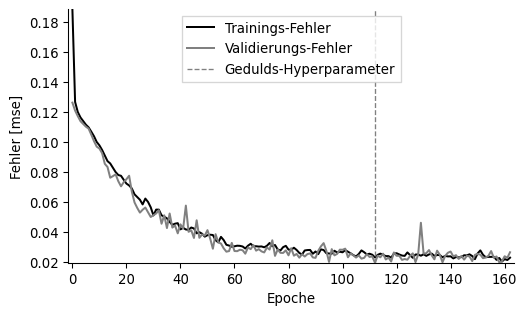

In [22]:
# Plot training loss for one best performing model
history = data_all[best_run["gaze"]]["history_all"]["gaze"]
print(history.keys())
train_loss = history['loss']
valid_loss = history['val_loss']

fig = plt.figure(figsize=(6,3.5), dpi=96)

# plt.title('Training- vs. Validation-Loss (mse)')
plt.ylabel('Fehler [mse]')
plt.xlabel('Epoche')
# plt.ylim(ymax = 0.2)
plt.margins(y=0,x=0.01)

plt.plot(
    train_loss, 
    label='Trainings-Fehler', 
    color="k"), 
plt.plot(
    valid_loss,
    label='Validierungs-Fehler', 
    color="grey")

plt.vlines(
    x=(len(train_loss)-51),
    ymin=min(valid_loss), 
    ymax=max(train_loss), 
    colors='grey', 
    ls='--', lw=1, 
    label='Gedulds-Hyperparameter')
plt.legend(
    loc='upper center', 
    fancybox=False, 
    shadow=False, 
    ncol=1) #bbox_to_anchor=(0.5, -0.15)
sns.despine()

plt.savefig(
    "plots/training_loss.png",
    bbox_inches='tight', 
    dpi=512)

## Explorative analysis

### Data visualisation

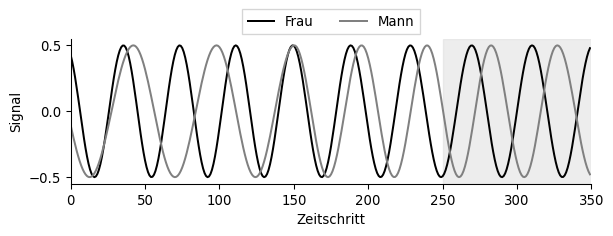

In [ ]:
# Plot single sample
sample_number = 20  # 2

fig = plt.figure(figsize=(7, 2), dpi=96)
sample_example = [
    [*samples["gaze"]["X_input_test"][sample_number, :, sex],
     *samples["gaze"]["y_output_test"][sample_number, :, sex]]
    for sex in [0, 1]
]

plt.plot(
    sample_example[0],
    color="k",
    label="Frau")
plt.plot(
    sample_example[1],
    color="grey",
    label="Mann")

# Put a legend below current axis
plt.ylabel('Signal')
plt.xlabel('Zeitschritt')
plt.legend(
    loc='center',
    bbox_to_anchor=(0.5, 1.12),
    fancybox=False,
    shadow=False,
    ncol=2)
plt.margins(x=0)
plt.yticks([0.5, 0, -0.5])
plt.axvspan(
    250, 350,
    color='gainsboro',
    alpha=0.5)

sns.despine()

plt.savefig(
    "plots/sample.png",
    bbox_inches='tight',
    dpi=512)


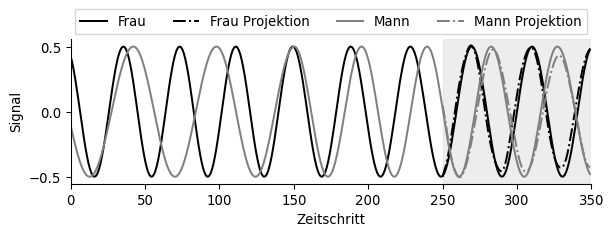

In [ ]:
# Plot single sample with predictions
prediction_example = [
    # add 250 nans at start
    [*samples["gaze"]["X_input_test"][sample_number,:,sex]*[np.nan],
     *predictions[best_run["gaze"]]["gaze"][sample_number,:,sex]]
    for sex in [0,1]
    ]

fig = plt.figure(figsize=(7,2), dpi=96)

plt.plot(
    sample_example[0], 
    color="k", 
    label = "Frau")
plt.plot(
    prediction_example[0], 
    ls="-.", 
    color="k", 
    label = "Frau Projektion")
plt.plot(
    sample_example[1], 
    color="grey", 
    label = "Mann")
plt.plot(
    prediction_example[1], 
    ls="-.", 
    color="grey", 
    label = "Mann Projektion")

plt.ylabel('Signal')
plt.xlabel('Zeitschritt')
plt.legend(
    loc='center', 
    bbox_to_anchor=(0.5, 1.12), 
    fancybox=False,
    shadow=False, 
    ncol=4)

plt.margins(x=0)
plt.yticks([0.5,0,-0.5])
plt.axvspan(
    250,350, 
    color='gainsboro',
    alpha=0.5)

sns.despine()

plt.savefig(
    "plots/sample2.png", 
    bbox_inches='tight',
    dpi=512)

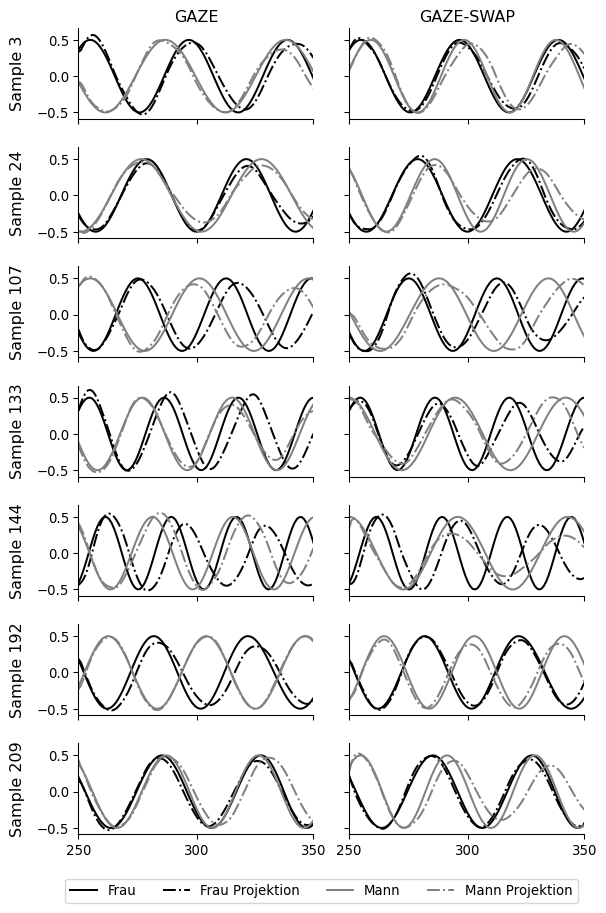

In [ ]:
# Get random sample indices for n samples
n = 7
sample_no = np.sort([
    randint(0, len(samples["gaze"]["y_output_test"])-1)
    for p in range(0, n)
])

n_rows = len(sample_no)
n_cols = 2
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(6, 9),
    dpi=96,
    sharey=True,
    sharex=True)
# fig.suptitle('Main title')
fig.tight_layout()

for row_num in range(n_rows):
    for col_num, con in enumerate(["gaze", "gaze_swap"]):
        ax = axes[row_num][col_num]
        ax.plot(
            samples[con]["y_output_test"][sample_no[row_num], :, 0],
            color="black",
            label="Frau")
        ax.plot(
            predictions[best_run[con]][con][sample_no[row_num], :, 0],
            color="black",
            ls="-.",
            label="Frau Projektion")
        ax.plot(
            samples[con]["y_output_test"][sample_no[row_num], :, 1],
            color="grey",
            label="Mann")
        ax.plot(
            predictions[best_run[con]][con][sample_no[row_num], :, 1],
            color="grey",
            ls="-.",
            label="Mann Projektion")
        # ax.set_title(f'Plot ({row_num+1}, {col_num+1})')
        ax.set_xticks([0, 50, 99])
        ax.set_xticklabels([250, 300, 350])
        ax.set_yticks([-0.5, 0, 0.5])
        ax.margins(x=0)
sns.despine()

row_headers = [f"Sample {str(x)}" for x in sample_no]
col_headers = ["GAZE", "GAZE-SWAP"]
# fontweight="bold")#, )#, fontfamily="monospace")
font_kwargs = dict(fontsize="large")
add_headers(
    fig,
    col_headers=col_headers,
    row_headers=row_headers,
    **font_kwargs)

# Code for legend based on https://stackoverflow.com/a/59393045
labels_handles = {
    label: handle for ax in fig.axes for handle,
    label in zip(*ax.get_legend_handles_labels())
}

fig.legend(
    labels_handles.values(),
    labels_handles.keys(),
    loc="upper center",
    bbox_to_anchor=(0.5, 0),
    bbox_transform=plt.gcf().transFigure,
    ncol=4)
plt.savefig(
    "plots/samples_pred.png",
    bbox_inches='tight',
    dpi=512)

plt.show()


### Data Distribution

#### Best performing model

Number of predicted data points: 139200
Percentage of outliers in predictions: 1.67 %
min: -0.6481
min: 0.6658


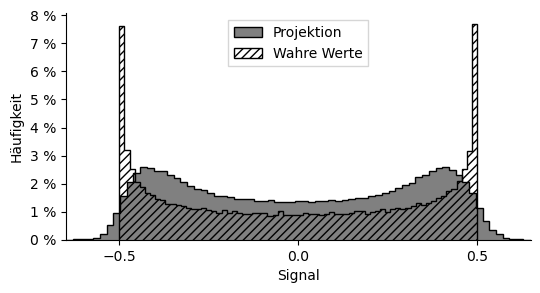

In [ ]:
# Gather all data from the best models
all_data_from_best_models = {
    "test_pred": np.array([
        predictions[best_run[con]][con].flatten()
        for con in conditions
    ]).flatten(),
    "test_true": np.array([
        samples[con]["y_output_test"].flatten()
        for con in conditions
    ]).flatten()
}

# Plot value distribution
all_data_from_best_models_keys = list(all_data_from_best_models.keys())
plt.figure(figsize=(6, 3), dpi=100)

# Set y ticks
num_datapoints = len(all_data_from_best_models['test_pred'])

# Set y ticks as percentage
plt.yticks(
    [num_datapoints*x/100 for x in range(10)],
    [f"{x} %" for x in range(10)])
# Set x ticks
plt.xticks([0.5, 0, -0.5])
plt.xlim([-0.65, 0.65])
plt.xlabel('Signal')
plt.ylabel('Häufigkeit')

plt.hist(
    all_data_from_best_models['test_pred'],
    bins=70,
    histtype='step',
    edgecolor='black',
    fill=True,
    color='grey',
    label='Projektion')
plt.hist(
    all_data_from_best_models['test_true'],
    bins=70,
    histtype='step',
    edgecolor='black',
    fill=False, hatch='////',
    label='Wahre Werte')
plt.legend(
    loc='upper center',
    fancybox=False,
    shadow=False,
    ncol=1)  # bbox_to_anchor=(0.5, -0.15)

sns.despine()
plt.savefig(
    "plots/data_distribution.png",
    bbox_inches='tight',
    dpi=512)
# Calculate outliers
outliers = sum([
    -0.5 > i < 0.5
    for i in all_data_from_best_models['test_pred']
])/num_datapoints*100
print(
    f"Number of predicted data points: {len(all_data_from_best_models['test_pred'])}")
print(f"Percentage of outliers in predictions: {outliers:.2f} %")
print(f"min: {min(all_data_from_best_models['test_pred']):.4f}")
print(f"min: {max(all_data_from_best_models['test_pred']):.4f}")

plt.show()

## Miscellaneous
Code from:
https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

In [ ]:
# plot MAE of all samples in time order, to see if there is clear pattern (which means more training is needed)
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

KeyError: 'train_pred'

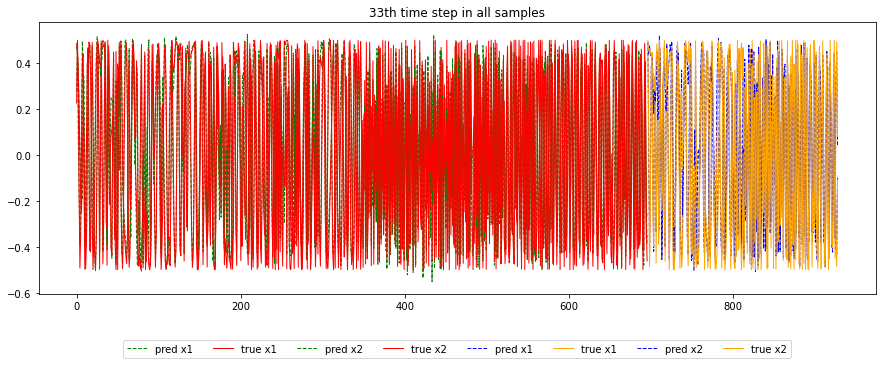

In [ ]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

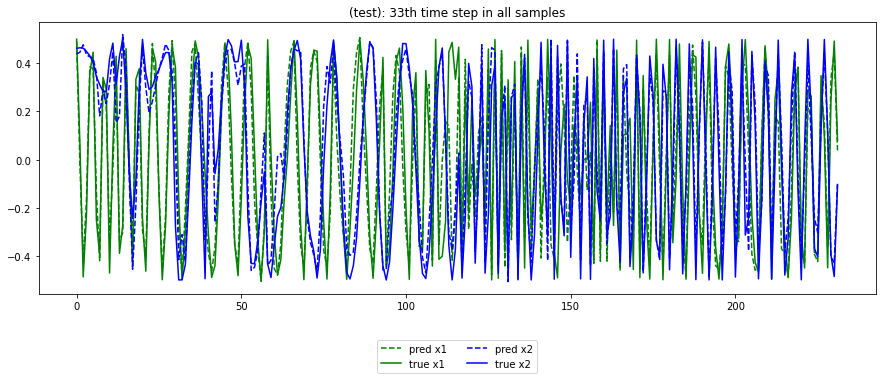

In [ ]:
# Check the nth prediction of each time step
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()